# Identifying best classification model on a subset of the data


In [129]:
import pandas as pd
import numpy as np
import timeit
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from collections import OrderedDict
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [130]:
all = pd.read_csv('insta_sample.csv')
dept = pd.read_csv('mer_products.csv')

In [131]:
all.user_id[all.eval_set == 'train'].unique().shape

(6390,)

In [132]:
all.user_id[all.eval_set == 'prior'].unique().shape

(10000,)

In [133]:
order_products_train = all[all.eval_set == 'train']
order_products_prior = all[all.eval_set == 'prior']

In [134]:
train_ids = order_products_train['user_id'].unique()
order_products_prior = order_products_prior[order_products_prior['user_id'].isin(
    train_ids)]

In [135]:
dept1 = dept.copy()
dept1 = dept1[['product_id', 'aisle_id', 'department_id']]
order_products_prior = pd.merge(order_products_prior, dept1, on=['product_id'])

In [136]:
order_products_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66576 entries, 0 to 1651119
Data columns (total 10 columns):
order_id           66576 non-null int64
product_id         66576 non-null int64
add_cart_order     66576 non-null int64
reordered          66576 non-null int64
user_id            66576 non-null int64
eval_set           66576 non-null object
order_number       66576 non-null int64
order_dow          66576 non-null int64
order_hour         66576 non-null int64
days_last_order    66576 non-null float64
dtypes: float64(1), int64(8), object(1)
memory usage: 5.6+ MB


In [137]:
order_products_train.nunique()

order_id            6390
product_id         13935
add_cart_order        61
reordered              2
user_id             6390
eval_set               1
order_number          96
order_dow              7
order_hour            24
days_last_order       31
dtype: int64

In [138]:
order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015388 entries, 0 to 1015387
Data columns (total 12 columns):
order_id           1015388 non-null int64
product_id         1015388 non-null int64
add_cart_order     1015388 non-null int64
reordered          1015388 non-null int64
user_id            1015388 non-null int64
eval_set           1015388 non-null object
order_number       1015388 non-null int64
order_dow          1015388 non-null int64
order_hour         1015388 non-null int64
days_last_order    951157 non-null float64
aisle_id           1015388 non-null int64
department_id      1015388 non-null int64
dtypes: float64(1), int64(10), object(1)
memory usage: 100.7+ MB


In [139]:
# imputing null values in the first order
order_products_prior.fillna(order_products_prior.days_last_order.mean(), inplace=True)

In [140]:
order_products_prior.isna().sum()

order_id           0
product_id         0
add_cart_order     0
reordered          0
user_id            0
eval_set           0
order_number       0
order_dow          0
order_hour         0
days_last_order    0
aisle_id           0
department_id      0
dtype: int64

In [141]:
insta = order_products_prior[['product_id', 'user_id']].drop_duplicates()

In [142]:
insta.shape

(417037, 2)

In [143]:
insta.user_id.unique().shape

(6390,)

In [144]:
# converting into binary classification problem
train_carts = (order_products_train.groupby('user_id', as_index=False)
                                   .agg({'product_id': (lambda x: set(x))})
                                   .rename(columns={'product_id': 'latest_cart'}))

insta = insta.merge(train_carts, on='user_id')
insta['in_cart'] = (insta.apply(lambda row: row['product_id']
                                in row['latest_cart'], axis=1).astype(int))
print(insta.sample(1))
print(insta.shape)

      product_id  user_id                                        latest_cart  \
8342       26497    83652  {22935, 22559, 48679, 12975, 47792, 45104, 219...   

      in_cart  
8342        0  
(417037, 4)


In [145]:
def get_user_split_data(df, test_size=.20, seed=42):

    rs = np.random.RandomState(seed)

    total_users = df['user_id'].unique()
    test_users = rs.choice(total_users,
                           size=int(total_users.shape[0] * test_size),
                           replace=False)
    df_te = df[df['user_id'].isin(test_users)]

    df_val_tr = df[~df['user_id'].isin(test_users)]

    val_tr_users = df_val_tr['user_id'].unique()

    val_users = (rs.choice(val_tr_users,
                           size=int(val_tr_users.shape[0] * test_size),
                           replace=False))

    df_tr = df_val_tr[~df_val_tr['user_id'].isin(val_users)]

    df_val = df_val_tr[df_val_tr['user_id'].isin(val_users)]

    y_tr, y_te, y_val = df_tr['in_cart'], df_te['in_cart'], df_val['in_cart']
    X_tr = df_tr.drop(
        ['product_id', 'user_id', 'latest_cart', 'in_cart'], axis=1)
    X_te = df_te.drop(
        ['product_id', 'user_id', 'latest_cart', 'in_cart'], axis=1)
    X_val = df_val.drop(
        ['product_id', 'user_id', 'latest_cart', 'in_cart'], axis=1)
    return X_tr, X_te, X_val, y_tr, y_te, y_val

# Feature Engineering

## Product / Department / Aisle features

In [146]:
p_features_names = ['p_total_orders', 'p_avg_add_cart_order']

p_features = (order_products_prior.groupby(['product_id'], as_index=False)
              .agg(OrderedDict(
                  [('order_id', 'nunique'),
                   ('add_cart_order', 'mean')])))
p_features.columns = ['product_id'] + p_features_names
p_features.sample(1)

,product_id,p_total_orders,p_avg_add_cart_order
25942,40848,1,24.0


In [147]:
p_features.shape

(31514, 3)

In [148]:
# product average day of week ordered
p_dow = order_products_prior.groupby(
    ['product_id'])[['order_dow']].mean().reset_index()
p_dow.columns = ['product_id', 'p_order_dow']
p_features = pd.merge(p_features, p_dow, on=['product_id'], how='left')
p_features.sample(1)

,product_id,p_total_orders,p_avg_add_cart_order,p_order_dow
7910,12535,3,6.0,4.0


In [149]:
p_features.shape

(31514, 4)

In [150]:
# product average hour ordered
p_hour = order_products_prior.groupby(
    ['product_id'])[['order_hour']].mean().reset_index()
p_hour.columns = ['product_id', 'p_order_hour']
p_features = pd.merge(p_features, p_hour, on=['product_id'], how='left')
p_features.head()

,product_id,p_total_orders,p_avg_add_cart_order,p_order_dow,p_order_hour
0,1,29,7.413793,2.931034,13.241379
1,2,3,12.000000,3.000000,16.000000
2,3,2,3.500000,4.500000,5.500000
3,4,14,11.214286,1.928571,13.928571
4,8,4,4.500000,3.000000,17.250000


In [151]:
# product reorder rate
reordered = order_products_prior.groupby(
    ['product_id'])[['reordered']].sum().reset_index()
reordered.columns = ['product_id', 'reorder_sum']
p_features = pd.merge(p_features, reordered, on=['product_id'], how='left')
p_features['p_reorder_rate'] = p_features.reorder_sum/p_features.p_total_orders

In [152]:
p_features.shape

(31514, 7)

In [153]:
# aisle reorder rate
opp_a = order_products_prior[['product_id', 'aisle_id']].drop_duplicates()
opp_a.sample(1)
p_features = pd.merge(p_features, opp_a, how='left', on=['product_id'])
reordered_a = order_products_prior.groupby(
    ['aisle_id'])[['reordered']].mean().reset_index()
reordered_a.columns = ['aisle_id', 'a_reorder_rate']
p_features = pd.merge(p_features, reordered_a, how='left', on='aisle_id')
p_features.drop(['aisle_id'], axis=1, inplace=True)

In [154]:
# department reorder rate
opp_d = order_products_prior[['product_id', 'department_id']].drop_duplicates()
opp_d.sample(1)
p_features = pd.merge(p_features, opp_d, how='left', on=['product_id'])
reordered_d = order_products_prior.groupby(
    ['department_id'])[['reordered']].mean().reset_index()
reordered_d.columns = ['department_id', 'd_reorder_rate']
print(reordered_d.shape)
p_features = pd.merge(p_features, reordered_d, how='left', on='department_id')
p_features.drop(['department_id'], axis=1, inplace=True)

(21, 2)


In [155]:
p_features.shape

(31514, 9)

In [156]:
insta = insta.merge(p_features, on='product_id')
print(insta.sample(1))

       product_id  user_id                                        latest_cart  \
83661        7948    92338  {6400, 30720, 24841, 49289, 21137, 22035, 2485...   

       in_cart  p_total_orders  p_avg_add_cart_order  p_order_dow  \
83661        0             702              8.343305     2.830484   

       p_order_hour  reorder_sum  p_reorder_rate  a_reorder_rate  \
83661     13.490028          375        0.534188        0.586935   

       d_reorder_rate  
83661        0.671604  


## User features

In [157]:
u_features_names = ['u_total_orders', 'u_avg_cartsize',
                    'u_total_products', 'u_avg_days_since_prior_order']

u_features = (order_products_prior.groupby(['user_id'], as_index=False)
              .agg(OrderedDict(
                  [('order_id', ['nunique', (lambda x: x.shape[0] / x.nunique())]),
                   ('product_id', 'nunique'),
                   ('days_last_order', 'mean')])))

u_features.columns = ['user_id'] + u_features_names
print(u_features.sample(1))
print(u_features.shape)

      user_id  u_total_orders  u_avg_cartsize  u_total_products  \
2741    89765              19       15.842105                83   

      u_avg_days_since_prior_order  
2741                     13.857759  
(6390, 5)


In [158]:
# user's TRAIN order - dow and hour info
u_train_dow_hour = order_products_train[['user_id', 'order_dow', 'order_hour']]

u_train_dow_hour.drop_duplicates(inplace=True)

u_train_dow_hour.columns = ['user_id', 'u_train_order_dow', 'u_train_hour']

u_features = pd.merge(u_features, u_train_dow_hour, on='user_id', how='left')

/home/dgou1218/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [159]:
insta = insta.merge(u_features, on='user_id', how='left')

## User-Product/Department features

In [160]:
#u_p total orders
u_p_features = (order_products_prior.groupby(['product_id', 'user_id'], as_index=False)
                .agg({'order_id': 'count'})
                .rename(columns={'order_id': 'u_p_total_orders'}))
u_p_features.sample(1)

,product_id,user_id,u_p_total_orders
228823,27735,73981,5


In [161]:
#u_p add cart order
u_p_features['u_p_avg_add_to_cart_order'] = (order_products_prior.groupby(['product_id', 'user_id'], as_index=False)
                                             .agg(OrderedDict(
                                                 [('add_cart_order', 'mean')]))['add_cart_order'])
order_products_prior.sample(2)

,order_id,product_id,add_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour,days_last_order,aisle_id,department_id
521954,2699154,25093,23,0,195514,prior,11,2,15,10.0,21,16
435455,849517,33273,5,0,12035,prior,14,3,15,1.0,41,8


In [162]:
# u_p order rate
u_p_num_ordered = order_products_prior.groupby(['user_id', 'product_id'], as_index=False)[
    ['order_id']].count()
u_p_num_ordered.columns = ['user_id', 'product_id', 'u_p_num_ordered']
u_p_features = pd.merge(u_p_features, u_p_num_ordered, on=[
                        'user_id', 'product_id'], how='left')
tot_orders = order_products_prior.groupby(
    'user_id', as_index=False)[['order_number']].max()
tot_orders.columns = ['user_id', 'user_total_orders']
u_p_features = pd.merge(u_p_features, tot_orders, on='user_id', how='left')
u_p_features['u_p_order_rate'] = u_p_features['u_p_num_ordered'] / \
    u_p_features['user_total_orders']
u_p_features.head(2)

,product_id,user_id,u_p_total_orders,u_p_avg_add_to_cart_order,u_p_num_ordered,user_total_orders,u_p_order_rate
0,1,10113,1,5.0,1,11,0.090909
1,1,11119,1,1.0,1,23,0.043478


In [163]:
# user dept order rate

u_d_num_ordered = order_products_prior.groupby(['user_id', 'department_id'], as_index=False)[
    ['order_id']].count()
u_d_num_ordered.columns = ['user_id', 'department_id', 'u_d_num_ordered']
u_d_num_ordered = pd.merge(u_d_num_ordered, tot_orders, on='user_id')
u_d_num_ordered['u_d_order_rate'] = u_d_num_ordered.u_d_num_ordered / \
    u_d_num_ordered.user_total_orders
u_d_order_rate = u_d_num_ordered.drop(
    ['u_d_num_ordered', 'user_total_orders'], axis=1)
opp_u_d = order_products_prior[[
    'user_id', 'product_id', 'department_id']].drop_duplicates()

In [164]:
u_d_features = pd.merge(opp_u_d, u_d_order_rate, on=[
                        'user_id', 'department_id'])
u_d_features.sample(1)

,user_id,product_id,department_id,u_d_order_rate
220635,161537,9862,7,1.638889


In [165]:
# last order number and number of orders since last purchase
last_order = order_products_prior.groupby(['user_id', 'product_id'], as_index=False)[
    ['order_number']].max()
last_order.columns = ['user_id', 'product_id', 'u_p_last_order_number']
u_p_features = pd.merge(u_p_features, last_order, on=[
                        'user_id', 'product_id'], how='left')
u_p_features['u_p_orders_since_last_purch'] = u_p_features['user_total_orders'] - \
    u_p_features['u_p_last_order_number']
u_p_features['u_p_in_last_order'] = (
    u_p_features['u_p_orders_since_last_purch'] == 1).astype(int)

In [166]:
# u_p average day of week ordered
u_p_dow = order_products_prior.groupby(['product_id', 'user_id'], as_index=False)[
    ['order_dow']].mean()
u_p_dow.columns = ['product_id', 'user_id', 'u_p_order_dow']
u_p_features = pd.merge(u_p_features, u_p_dow, on=[
                        'product_id', 'user_id'], how='left')
u_p_features.sample(1)

,product_id,user_id,u_p_total_orders,u_p_avg_add_to_cart_order,u_p_num_ordered,user_total_orders,u_p_order_rate,u_p_last_order_number,u_p_orders_since_last_purch,u_p_in_last_order,u_p_order_dow
243432,29334,93764,3,12.666667,3,33,0.090909,18,15,0,4.666667


In [167]:
u_p_hour = order_products_prior.groupby(['product_id', 'user_id'], as_index=False)[
    ['order_hour']].mean()
u_p_hour.columns = ['product_id', 'user_id', 'u_p_order_hour']
u_p_features = pd.merge(u_p_features, u_p_hour, on=[
                        'product_id', 'user_id'], how='left')
u_p_features.sample(1)

,product_id,user_id,u_p_total_orders,u_p_avg_add_to_cart_order,u_p_num_ordered,user_total_orders,u_p_order_rate,u_p_last_order_number,u_p_orders_since_last_purch,u_p_in_last_order,u_p_order_dow,u_p_order_hour
370425,44632,5105,5,11.6,5,16,0.3125,16,0,0,4.0,12.4


In [168]:
# merging u_p_features with insta
insta = insta.merge(u_p_features, on=['user_id', 'product_id'])

insta = insta.merge(u_d_features, on=['user_id', 'product_id'])

#insta['u_p_order_freq'] = insta['u_p_total_orders'] / insta['user_total_orders']
insta['u_p_delta_hour'] = insta.u_p_order_hour - insta.u_train_hour
insta['u_p_delta_dow'] = insta.u_p_order_dow - insta.u_train_order_dow
insta['p_delta_hour'] = insta.p_order_hour - insta.u_train_hour
insta['p_delta_dow'] = insta.p_order_dow - insta.u_train_order_dow

insta.drop(['u_p_order_hour', 'p_order_hour', 'u_p_order_dow', 'p_order_dow', 'u_train_hour',
            'u_train_order_dow', 'reorder_sum',  'user_total_orders','u_p_num_ordered', 
            'u_p_last_order_number','department_id'], axis=1, inplace=True)


In [169]:
insta.shape

(417037, 23)

In [170]:
print(insta.columns, '\n', len(insta.columns))

Index(['product_id', 'user_id', 'latest_cart', 'in_cart', 'p_total_orders',
       'p_avg_add_cart_order', 'p_reorder_rate', 'a_reorder_rate',
       'd_reorder_rate', 'u_total_orders', 'u_avg_cartsize',
       'u_total_products', 'u_avg_days_since_prior_order', 'u_p_total_orders',
       'u_p_avg_add_to_cart_order', 'u_p_order_rate',
       'u_p_orders_since_last_purch', 'u_p_in_last_order', 'u_d_order_rate',
       'u_p_delta_hour', 'u_p_delta_dow', 'p_delta_hour', 'p_delta_dow'],
      dtype='object') 
 23


# Modeling

In [171]:
# splitting the data into test, val, train subsets function
def get_user_split_data(df, test_size=.20, seed=42):

    rs = np.random.RandomState(seed)

    total_users = df['user_id'].unique()
    test_users = rs.choice(total_users,
                           size=int(total_users.shape[0] * test_size),
                           replace=False)
    df_te = df[df['user_id'].isin(test_users)]

    df_val_tr = df[~df['user_id'].isin(test_users)]

    val_tr_users = df_val_tr['user_id'].unique()

    val_users = (rs.choice(val_tr_users,
                           size=int(val_tr_users.shape[0] * test_size),
                           replace=False))

    df_tr = df_val_tr[~df_val_tr['user_id'].isin(val_users)]

    df_val = df_val_tr[df_val_tr['user_id'].isin(val_users)]

    y_tr, y_te, y_val = df_tr['in_cart'], df_te['in_cart'], df_val['in_cart']
    X_tr = df_tr.drop(
        ['product_id', 'user_id', 'latest_cart', 'in_cart'], axis=1)
    X_te = df_te.drop(
        ['product_id', 'user_id', 'latest_cart', 'in_cart'], axis=1)
    X_val = df_val.drop(
        ['product_id', 'user_id', 'latest_cart', 'in_cart'], axis=1)
    return X_tr, X_te, X_val, y_tr, y_te, y_val

In [172]:
# splitting the data
X_tr, X_te, X_val, y_tr, y_te, y_val = get_user_split_data(insta)

## Model= All prev ordered products

In [173]:
y_1 = np.ones(len(y_te))
print('All prev purchases model:')
print('f1 score = ', f1_score(y_te, y_1))
print('precision = ', precision_score(y_te,y_1))
print('recall = ', recall_score(y_te, y_1))

All prev purchases model:
f1 score =  0.17057393418424938
precision =  0.0932390422174233
recall =  1.0


## Model = Last cart

In [174]:
insta2 = X_te.copy()
y_last = X_te.u_p_in_last_order
print('Last cart model:')
print('f1 score = ', f1_score(y_te, y_last))
print('precision score = ', precision_score( y_te, y_last))
print('recall= ', recall_score(y_te, y_last))

Last cart model:
f1 score =  0.1672823828215193
precision score =  0.15307416015212338
recall=  0.18439806566556374


## Logistic Regression

In [175]:
starttime = timeit.default_timer()

lr = LogisticRegression(C=1, class_weight={1: 5, 0: 1}, max_iter=300)
lr.fit(X_tr, y_tr)
score = f1_score(y_val, lr.predict(X_val))
print('f1 score = ', score)

print("The time difference is :", timeit.default_timer() - starttime)

f1 score =  0.40036507453605114
The time difference is : 10.113730399985798


/home/dgou1218/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [176]:
print('Precision Score =', precision_score(y_val, lr.predict(X_val)))

Precision Score = 0.3324911571500758


In [177]:
print('Recall Score =', recall_score(y_val, lr.predict(X_val)))

Recall Score = 0.5030581039755352


## XGBoost

In [178]:
xgb = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=8,
    objective="binary:logistic",
    learning_rate=.1,
    subsample=1,
    min_child_weight=0.8,
    colsample_bytree=.8,
    scale_pos_weight=3.8
)

In [179]:
starttime = timeit.default_timer()
eval_set = [(X_tr, y_tr), (X_val, y_val)]  # tracking train error as we go
xgb.fit(
    X_tr, y_tr,
    eval_set=eval_set,
    eval_metric='aucpr',
    early_stopping_rounds=20,
    verbose=False
)

print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 17.85518630000297


In [180]:
xgb.best_ntree_limit

47

In [181]:
f1_score(y_te,xgb.predict(X_te, ntree_limit=xgb.best_ntree_limit))

0.41565149048447764

In [182]:
recall_score(y_te,xgb.predict(X_te, ntree_limit=xgb.best_ntree_limit))

0.4711122423008399

In [183]:
precision_score(y_te, xgb.predict(X_te, ntree_limit=xgb.best_ntree_limit))

0.37187343043696636

In [184]:
print("XGBClassifier confusion matrix: \n\n", confusion_matrix(y_te, xgb.predict(X_te, ntree_limit=xgb.best_ntree_limit)))

XGBClassifier confusion matrix: 

 [[70167  6253]
 [ 4156  3702]]


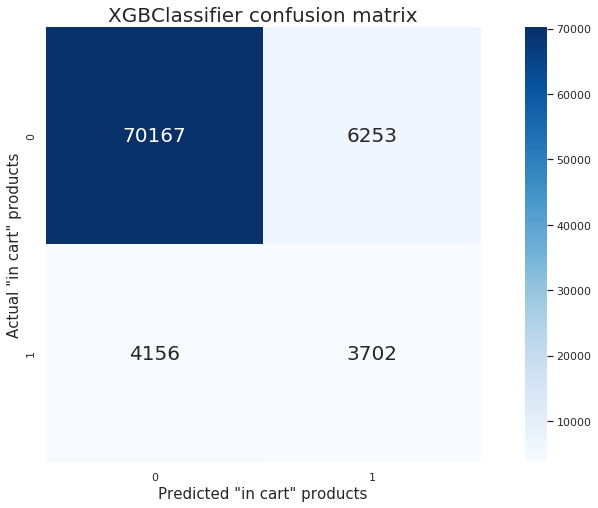

In [185]:
# Print confusion matrix for xgb
xgb_confusion = confusion_matrix(y_te, xgb.predict(X_te, ntree_limit=xgb.best_ntree_limit))

plt.figure(figsize=(16,8))
ax=sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d', annot_kws={"size": 20})
plt.xlabel('Predicted "in cart" products', fontsize=15)
plt.ylabel('Actual "in cart" products', fontsize=15)
plt.title('XGBClassifier confusion matrix', fontsize=20);

## Feature importance

('u_p_orders_since_last_purch', 0.33385754) 

('u_p_order_rate', 0.23389834) 

('u_p_total_orders', 0.13914146) 

('u_p_in_last_order', 0.03028773) 

('p_reorder_rate', 0.028600968) 

('u_total_orders', 0.026421163) 

('a_reorder_rate', 0.023563942) 

('u_total_products', 0.01924929) 

('u_avg_days_since_prior_order', 0.01850537) 

('u_avg_cartsize', 0.018300753) 

('p_total_orders', 0.018018126) 

('u_d_order_rate', 0.014779536) 

('d_reorder_rate', 0.0141046) 

('p_delta_dow', 0.013947363) 

('p_avg_add_cart_order', 0.013731695) 

('p_delta_hour', 0.013615782) 

('u_p_delta_dow', 0.013569983) 

('u_p_delta_hour', 0.013522407) 

('u_p_avg_add_to_cart_order', 0.012883995) 



([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text yticklabel objects>)

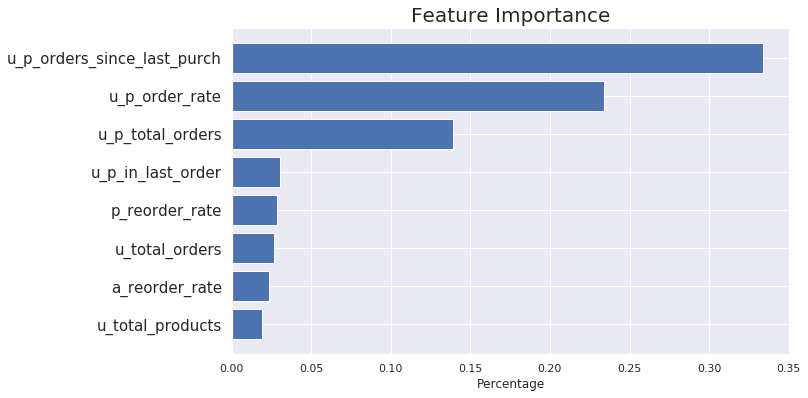

In [186]:
f_imp = zip(X_te.columns, xgb.feature_importances_)
f_imp = sorted(f_imp, key=lambda x: x[1], reverse=True)
for i in f_imp:
    print(i, '\n')

df = pd.DataFrame(list(f_imp), columns=['f', 'fe']).head(
    8).sort_values(by='fe')
plt.figure(figsize=(10, 6))
plt.barh(df.f, df.fe)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Percentage')
plt.yticks(fontsize=15)